In [60]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

In [61]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(in_features=64*6*6, out_features=600)
        self.drop = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=600, out_features=120)
        self.fc3 = nn.Linear(in_features=120, out_features=10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.flatten(out)
        out = self.fc1(out)
        out = self.drop(out)
        out = self.fc2(out)
        out = self.fc3(out)
        
        return out

In [62]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

batch_size = 1024
learning_rate = 0.001
num_epochs = 20

transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)
print(f"Rozmiar datasetu treningowego: {len(train_dataset)}")
print(f"Rozmiar datasetu testowego: {len(test_dataset)}")

model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


Rozmiar datasetu treningowego: 60000
Rozmiar datasetu testowego: 10000


In [63]:
def calculate_accuracy(loader, model):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

train_accuracy_history = []
test_accuracy_history = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_accuracy = calculate_accuracy(train_loader, model)
    test_accuracy = calculate_accuracy(test_loader, model)
    train_accuracy_history.append(train_accuracy)
    test_accuracy_history.append(test_accuracy)

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}, '
          f'Train Accuracy: {train_accuracy:.2f}%, Test Accuracy: {test_accuracy:.2f}%')

Epoch [1/20], Loss: 0.6657, Train Accuracy: 86.85%, Test Accuracy: 85.71%
Epoch [2/20], Loss: 0.3437, Train Accuracy: 89.72%, Test Accuracy: 88.36%
Epoch [3/20], Loss: 0.2941, Train Accuracy: 90.36%, Test Accuracy: 88.47%
Epoch [4/20], Loss: 0.2684, Train Accuracy: 90.88%, Test Accuracy: 89.04%
Epoch [5/20], Loss: 0.2445, Train Accuracy: 91.75%, Test Accuracy: 89.88%
Epoch [6/20], Loss: 0.2271, Train Accuracy: 92.65%, Test Accuracy: 90.39%
Epoch [7/20], Loss: 0.2158, Train Accuracy: 90.83%, Test Accuracy: 88.83%
Epoch [8/20], Loss: 0.2086, Train Accuracy: 93.07%, Test Accuracy: 90.34%
Epoch [9/20], Loss: 0.2026, Train Accuracy: 94.05%, Test Accuracy: 91.13%
Epoch [10/20], Loss: 0.1808, Train Accuracy: 94.23%, Test Accuracy: 90.69%
Epoch [11/20], Loss: 0.1812, Train Accuracy: 93.98%, Test Accuracy: 90.57%
Epoch [12/20], Loss: 0.1758, Train Accuracy: 94.09%, Test Accuracy: 90.58%
Epoch [13/20], Loss: 0.1691, Train Accuracy: 94.55%, Test Accuracy: 90.83%
Epoch [14/20], Loss: 0.1518, Train

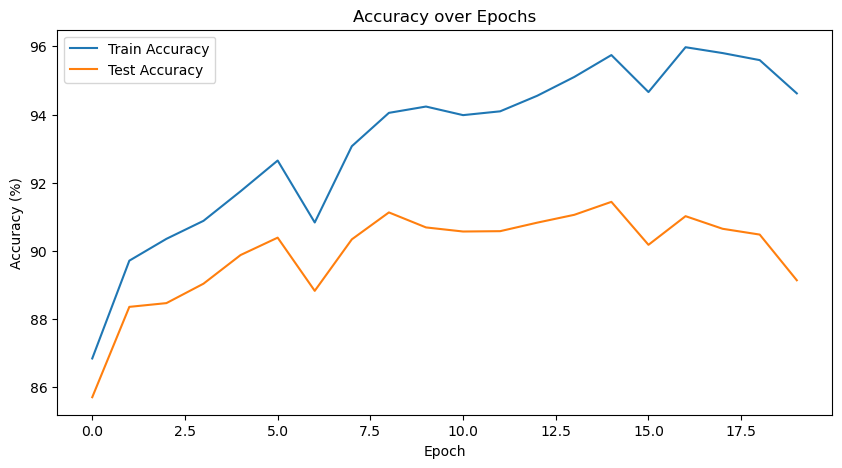

In [64]:
plt.figure(figsize=(10, 5))
plt.plot(train_accuracy_history, label='Train Accuracy')
plt.plot(test_accuracy_history, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

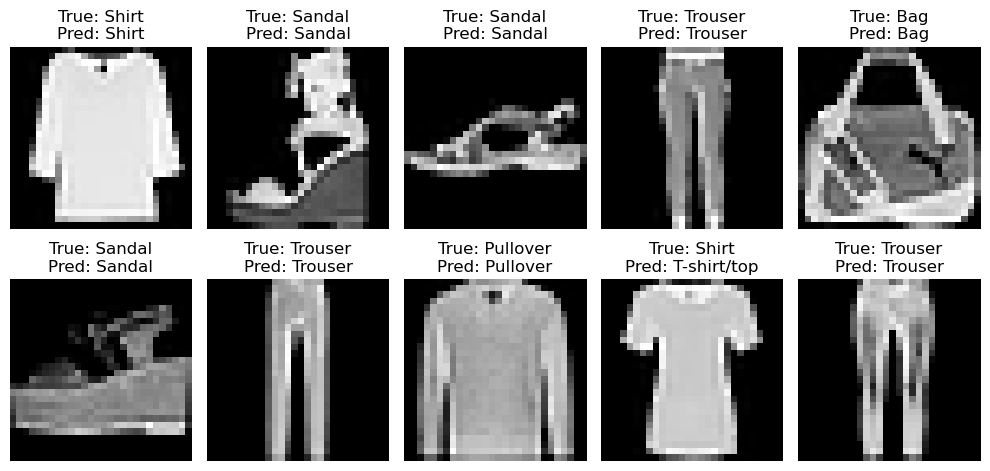

In [65]:
# model = torch.load("fashion_mnist_cnn.pth", weights_only=False)

model.eval()
fig, axes = plt.subplots(2, 5, figsize=(10, 5))
axes = axes.ravel()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

with torch.no_grad():
    for i in range(10):
        random_idx = random.randint(0, len(test_dataset) - 1)
        image, label = test_dataset[random_idx]
        image = image.unsqueeze(0).to(device)

        output = model(image)
        _, predicted = torch.max(output, 1)
        predicted_label = predicted.item()

        image = image.squeeze(0).cpu().numpy()
        axes[i].imshow(np.transpose(image, (1, 2, 0)), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'True: {class_names[label]}\nPred: {class_names[predicted_label]}')

plt.tight_layout()
plt.show()

torch.save(model.state_dict(), 'fashion_mnist_cnn.pth')
